
# Temperate Ecohydrology


Here we discuss some simple problems in ecosystem hydrology, which, for ATS, means integrated surface and subsurface hydrology along with sources/sinks representing evapotranspiration and other land surface processes.

We describe a few different problems, including:

* **spinup** which aims to get the background soil water state comparable to antecedent water conditions
* **prescribed P - ET** which assumes that ET is known from data or another model
* **prescribed transpiration** where we assume that transpiration is known, and it is distributed to a rooting zone
* **Priestley-Taylor ET**: a simple model for total ET


Author: Ethan Coon

In [1]:
%matplotlib ipympl

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import colors
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar
import pandas

import h5py


## Spinup

For applications of temperate ecohydrology, spinup is all about getting antecedent soil moisture conditions correct.  There can be no expectation of getting reasonable hydrographs if the antecedent soil moisture field is wrong.

One way of beginning this process is to solve, to pseudo-steady state, the integrated hydrology problem with a constant source term that is given by the mean annual (or mean seasonal) precipitation minus evapotranspiration (P-ET) rate.  This can be solved for long times, using an adaptive timestep that grows as the solution approaches steady state.  This sets the mean background conditions for simulations with daily or other high-resolution inputs.

The first step is to provide an initial condition for that run which is hydrostatic with the water table at the surface.  Starting from fully saturated and drawing down to the steady state is faster and more efficient than starting from dry and filling up to the steady state.  To do this, we don't assume that this is a hillslope with fixed slope, but imagine that it is set by topography and therefore cannot be provided analytically.

To do this, we use the hydrostatic initial condition option.  Given that initial condition, we solve to steady state.  In this solve, we often use a too-large Manning's coefficient.  This slows up the surface water, which is safe to do because we're looking at such long time scales.  Surface water is still much faster than subsurface water, and as long as we aren't trying to get high frequency hydrographs correct, this makes for much faster simulations (with longer timestep sizes) with little loss in predictive power.

This run is for 20,000 days and is plotted below.  The image is a bit hard to see without exaggerating in the vertical -- a better way of seeing these runs is to open it in VisIt.

In [3]:
# plot the saturation at steady-state
directory = "spinup.demo"

vis = ats_xdmf.VisFile(directory, time_unit='d')
vis.loadMeshPolygons()

fig, ax = plt.subplots(1,1,figsize=(12,8))
def plot(i, ax):
    cax = colorbar.make_axes(ax, 'right')[0]
    cax.set_ylabel("saturation [-]")

    sat = vis.get("saturation_liquid", vis.cycles[i])
    poly = vis.getMeshPolygons(cmap='jet_r', linewidth=0)
    poly.set_array(sat)
    poly.set_clim(0.4,1)
    ax.add_collection(poly)

    ax.axis('auto')

plot(0, ax)




AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# plot the runoff and, more clearly, the total water content in the subsurface to see if we are at steadystate
fig, ax = plt.subplots(1,2, figsize=(13,3))

flux = pandas.read_csv(os.path.join(directory, 'surface_outlet_flux.dat'), comment='#')
ax[0].semilogy(flux['time [s]'][:]/86400., flux['surface outlet flux'][:]/55000., 'b')
ax[0].set_xlabel('time [d]')
ax[0].set_ylabel('flux [m^3 / s]')

wc = pandas.read_csv(os.path.join(directory, 'water_content.dat'), comment='#')
ax[1].plot(wc['time [s]'][:]/86400., wc[list(wc.keys())[1]][:], 'b')
ax[1].set_xlabel('time [d]')
ax[1].set_ylabel('water content [mol]')

plt.show()


## Prescribed P - ET

Often precipitation and evapotranspiration are known from either a preexisting land model run, remotely sensed or point data (e.g. eddy flux towers and weather stations) or other approaches.  Here we do a few examples to generate datasets for use in ATS and then drive simulations with this prescribed data.


### Data processing

Below is an example of how to generate, from raw data, the input files needed by ATS for P, E, and T for these examples.  Included here is output from a CLM 4.5 run for the Asu Basin outside Manaus, Brazil.  This run provides daily data of a variety of the water balance fluxes, including precipitation, evaporation, and transpiration.  We read this file and generate the two HDF5 forcing files for use in ATS in the prescribed P-ET examples.

In [ ]:
#
# load the data
#
data = np.genfromtxt("data/flux_output_w_fluxtowerR.txt", names=True)

# note this read with column headers -- the file contains:
print(data.dtype)

# daily data, converted to [s].  Note there are some units options in ATS, but it is easiest to 
# write data in SI units.
times = np.array(range(len(data)))
times = times * 86400.

# precip, evap, and trans are all in [mm/s], and so must be converted to [m/s] for use in ATS
precip = 1.e-3 * data['atmospheric_rainmms']
evap = 1.e-3 * (data['vegetation_evaporationmms'] + data['ground_evaporationmms'])
trans = 1.e-3 * data['vegetation_transpirationmms']

# plot the data
fig, axs = plt.subplots(2,1,figsize=(13,6))
def plot(ax):
    fac = 1.e3 * 86400
    ax.plot(times/86400., precip*fac, 'b', label='precip')
    ax.plot(times/86000., evap*fac, 'r', label='evap')
    ax.plot(times/86400., trans*fac, color='forestgreen', label='trans')
    ax.legend(loc='upper right')
    ax.set_xlabel('time [d]')
    ax.set_ylabel('water flux [mm/day]')

plot(axs[0])
plot(axs[1])
axs[1].set_ylim(0, 6)

# write to disc
with h5py.File('data/prescribed_pet.h5','w') as fid:
    fid.create_dataset('time [s]', data=times)
    fid.create_dataset('precipitation [m s^-1]', data=precip)
    fid.create_dataset('evaporation [m s^-1]', data=evap)
    fid.create_dataset('transpiration [m s^-1]', data=trans)    
    fid.create_dataset('p_minus_et [m s^-1]', data=(precip - evap - trans))
    fid.create_dataset('p_minus_e [m s^-1]', data=(precip - evap))

plt.show()


### Daily forced simulations

Given the steady-state initial condition and the forcing data, we now run simulations forced by daily P-ET data.  Here we consider two choices -- first a run where P - ET is prescribed as a single entity as a function of time, and a second run where P - E is prescribed as a function of time while T is separated out.  

In the former case, the net water source is provided to the surface system (`prescribed_surface_evaporation.xml`).  This is often problematic.  Specifically, in most places, T can be order P, and pulling that much water from the surface isn't always possible -- the top grid cell dries out and cannot get water to the surface fast enough.  Therefore a limiter must be applied to the ET to ensure it does not dry out a grid cell too much.  This is especially problematic in 3D integrated hydrology simulations, where often the ET is calculated via a column model using an "average" depth to water table, which is significantly less than the depth to water table at, for instance, the top of a hillslope in a 3D run.

In the latter case, P-E is provided as a source to the surface system, while T is then distributed to a subsurface sink using a root profile for Plant Functional Type (PFT)-based vegetation (`prescribed_transpiration.xml`).  This is much more effective because the PFT rooting-depth based transpiration allows T to pull from depth, and has a native limiter on it based on soil moisture (or is it mafic potential?).  Note that the E may _still_ need to be limited, but typically, as E < P,T, this is less frequently a problem and typically full evaporation is taken and the limiter can be quite less of an issue.  

In these runs we did need a limiter for the surface ET case, but not for the distributed T case.

Note the limiters used here are quite naive -- better limiters should be implemented before this approach is used for real science.

Note that the hydrographs in the distributed case are drier, because ET was not limited and full transpiration was taken.

In [ ]:
directory_p_et = 'prescribed_surface_evaporation.demo'
directory_p_e_t = 'prescribed_transpiration.demo'

# plot the hydrographs
fig, ax = plt.subplots(1,1)

def plot(ax, directory, name, color):
    flux = pandas.read_csv(os.path.join(directory, 'water_balance.dat'), comment='#')
    ax.plot(flux['time [d]'][:], flux['runoff generation [mol d^-1]'][:]/55000., color=color, label=name)

plot(ax, directory_p_et, 'surface', 'b')
plot(ax, directory_p_e_t, 'distributed', 'r')
ax.legend()
ax.set_xlabel('time [days]')
ax.set_ylabel('flow rate [m^3 / s]')
plt.show()

# Empirical evapotranspiration

Many empirical models of evapotranspiration have been defined.  One of the most commonly used is the Priestley-Taylor model, which is itself a variant of the Penman-Monteith equation.  Our implementation follows that of USGS's PRMS model.

Under the first example, we simply impose incoming shortwave radiation as the net radiation balance.  The ground surface temperature, needed to compute the ground conduction term, is given by yesterday's air temperature.  Snow is included as a simple bucket model, with sources due to precipitation and sinks due to an empirical melting model (also based on PRMS) give by a melting degree-day.  The Priestley-Taylor equations provide potential transpiration -- this flux is then allocated to grid cells in the shallow subsurface based on a model from CLM version 4.5 that includes rooting distribution parameters and a limiter based on mafic potential of full turgor and that of the wilting point.

- INSERT CITATION of PRMS
- INSERT CITATION of CLM v4.5 Tech note


In [10]:
def plot(dirname, axs=None, label=None):
    obs = pandas.read_csv(os.path.join(dirname, 'water_balance.dat'), comment='#')
    if axs is None:
        fig,axs = plt.subplots(1,2, figsize=(12,6))
    
    axs[0].plot(obs['time [d]'], obs['runoff generation [mol d^-1]'] / 55500, label=label)
    axs[0].set_xlabel('time [d]')
    axs[0].set_ylabel('runoff [m^3 / d]')
    
    axs[1].plot(obs['time [d]'], obs['evapotranspiration [m d^-1]'])
    axs[1].set_xlabel('time [d]')
    axs[1].set_ylabel('transpiration [m / d]')
    return axs

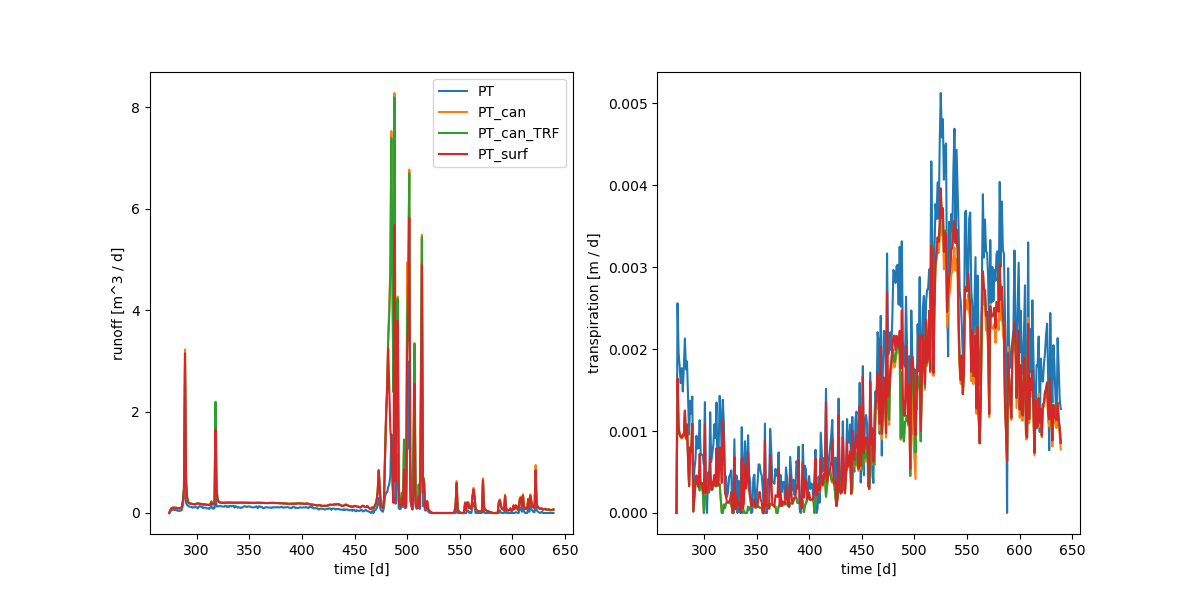

In [13]:
axs = plot('priestley_taylor.demo', label='PT')
plot('priestley_taylor_canopy_evapotranspiration.demo', axs, label='PT_can')
plot('priestley_taylor_canopy_evapotranspiration_relperm_trf.demo', axs, label='PT_can_TRF')
plot('priestley_taylor_canopy_evapotranspiration_relperm_trf_surftemp.demo', axs, label='PT_surf')
axs[0].legend()
plt.show()

In [ ]:
plot('priestley_taylor.demo')

In [ ]:
plot('priestley_taylor_canopy_evapotranspiration.demo')

In [ ]:
plot('priestley_taylor_canopy_evapotranspiration_relperm_trf.demo')

In [ ]:
plot('priestley_taylor_canopy_evapotranspiration_relperm_trf_surftemp.demo')

In [ ]:
plot('full_energy.demo')

In [ ]:
plot('simple_energy.demo')

## Prescribed LAI, calculated transpiration

More realistic than prescribing transpiration is to actively calculate transpiration as a function of photosynthesis.  This can be done through vegetation models, which actively simulate a carbon cycle and predict LAI and photosynthesis, or through a biophysics model, which takes as input a prescribed LAI as a function of time (including, e.g. seasonal variations) and calculates photosynthesis, stomatal conductance, and transpiration.

These approaches need no limiters -- the limiter is in the stomatal conductance term, which is itself a function of soil moisture or mafic potential.

**TO DO** This is not yet implemented -- the veg model and the biophysics calculation are in the same PK, and need to be refactored and split before this is possible.  _ETC_